In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import glob
from tqdm import tqdm

First we need to extract useful information from the downloaded chunk of data. 

In [2]:
def process_result(res):
    serious = res.get('serious', '2')
    out_list = []

    if serious != '1':
        return out_list
    patient = res['patient']
    patientage = patient.get('patientagegroup', None)
    patientsex = patient.get('patientsex', None)
    drugs = patient.get('drug', [])
    reactions = patient.get('reaction', [])
    all_reactions = [reaction.get('reactionmeddrapt', None) for reaction in reactions]
    added_drugs_names = set()
    for reaction in all_reactions:
        for drug in drugs:
            medprod = drug.get('medicinalproduct', None)
            if medprod in added_drugs_names:
                continue
            if medprod is not None:
                added_drugs_names.add(medprod)
            drugcar = drug.get('drugcharacterization', None)
            drugindication = drug.get('drugindication', None)
            try:
                active_subs = drug['activesubstance']['activesubstancename']
            except:
                active_subs = None
            
            out_list.append(dict(safetyreportid = res['safetyreportid'],
                                 reaction = reaction,
                                 drugind = drugindication,
                                 drugcar = drugcar,
                                 active_subs = active_subs
                                ))
    return out_list 
    
    
def merge_all_files(filenames):
    full_list = []
    for filename in tqdm(filenames):
        try:
            with open(filename) as f:
                data = json.load(f)['results']
        except:
            continue
        for res in data:
            try:
                full_list.extend(process_result(res))
            except Exception as e:
                print(e)
                continue
        del(data)
        
    return full_list

In [3]:
filenames = glob.glob('./data/*.json')
full_list = merge_all_files(filenames)
df = pd.DataFrame(full_list)
df.to_csv('Merged_data.csv')
del(full_list)

100%|█████████████████████████████████████████████████████████████████████████████████| 33/33 [03:14<00:00,  5.90s/it]


In [782]:
df.head()

,safetyreportid,reaction,drugind,drugcar,active_subs
0,18482094,DRUG DEPENDENCE,PRODUCT USED FOR UNKNOWN INDICATION,1,HYDROMORPHONE
1,18482094,DRUG DEPENDENCE,PRODUCT USED FOR UNKNOWN INDICATION,1,FENTANYL
2,18482094,DRUG DEPENDENCE,PRODUCT USED FOR UNKNOWN INDICATION,1,MORPHINE SULFATE
3,18482094,DRUG DEPENDENCE,PRODUCT USED FOR UNKNOWN INDICATION,1,HYDROMORPHONE HYDROCHLORIDE
4,18482094,DRUG DEPENDENCE,PRODUCT USED FOR UNKNOWN INDICATION,1,OXYCODONE HYDROCHLORIDE


In [783]:
df.describe()

,safetyreportid,reaction,drugind,drugcar,active_subs
count,743221,743221,564424,743221,733677
unique,218597,6678,4673,3,4573
top,16208690,DEATH,PRODUCT USED FOR UNKNOWN INDICATION,1,RANITIDINE HYDROCHLORIDE
freq,110,37203,231813,420406,40119


In [784]:
tot_db_size = len(df)
print(tot_db_size)

743221


We can notice that there are ~1 million drug/reaction combinations but onlly ~6k of different active substance and ~8k of different reactions

In [785]:
subs_ind = df[['active_subs', 'drugind']].dropna().drop_duplicates()

In [786]:
unique_act = df['active_subs'].value_counts().sort_values(ascending=False)

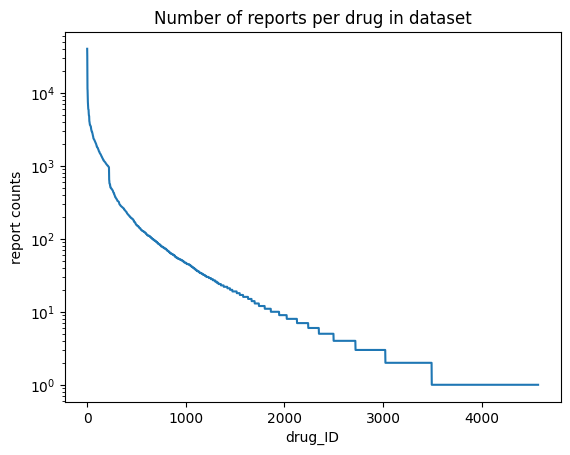

In [787]:
plt.plot(unique_act.values)
plt.yscale('log')
plt.xlabel('drug_ID')
plt.ylabel('report counts')
plt.title('Number of reports per drug in dataset');

Lets focus only on drugs with substancial occurances, and take sqrt(N) of a broad estimate of needed statistics

In [788]:
min_statistics = np.sqrt(len(df))
print(min_statistics)

862.1026621000541


In [789]:
represented_drugs = unique_act[unique_act>min_statistics]
print(f'Number of sufficiently represented drugs is {len(represented_drugs)}')

Number of sufficiently represented drugs is 222


Let's look for sufficiently represented reactions

In [790]:
df.reaction = df.reaction.str.upper()
df.drugind = df.drugind.str.upper()

In [791]:
unique_reac = df['reaction'].value_counts().sort_values(ascending=False)

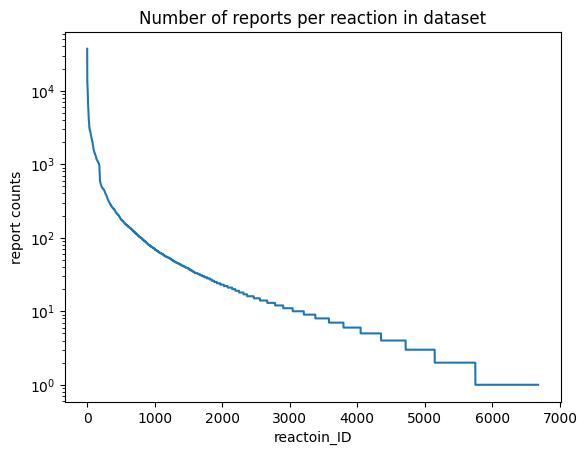

In [792]:
plt.plot(unique_reac.values)
plt.yscale('log')
plt.xlabel('reactoin_ID')
plt.ylabel('report counts')
plt.title('Number of reports per reaction in dataset');

Similar patterns as with drugs, so lets again take only representative ones


In [793]:
represented_reactions = unique_reac[unique_reac>min_statistics]
print(f'Number of sufficiently represented drugs is {len(represented_reactions)}')

Number of sufficiently represented drugs is 182


Now we will take subset of all data that contain either represented drugs or represented reactions


In [794]:
df = df[df.reaction.isin(represented_reactions.index.values)|df.active_subs.isin(represented_drugs.index.values)]

In [795]:
df.describe()

,safetyreportid,reaction,drugind,drugcar,active_subs
count,743221,743221,564424,743221,733677
unique,218597,6678,4673,3,4573
top,16208690,DEATH,PRODUCT USED FOR UNKNOWN INDICATION,1,RANITIDINE HYDROCHLORIDE
freq,110,37203,231813,420406,40119


### Drug - reaction correlation

It is tempting to try to answer if some reaction was induced by some drug. Note that even to estimate correlation we would need how many times drug provoke no adverse effect and, hence, is not in this database; and how many times the effects happens when the drug is not taken. 

Seems that one way to 'hint' if the drug is correlated with the adverse event is to look for PRR -Proportional Reporting Ratio (FDA whitepaper). PRR compares ratio of the effect among all the effects excluding the drug in question, and ratio of that effect with the drug is present among all other effects the drug was reported with. 
Here the assumption is that the database is diverse enough to estimate the spontanious adverse effect unrelated to any drugs, that might not hold if there are overrepresentations of certain drugs/reactions.

In [796]:
count_per_reaction = df.groupby('reaction')['safetyreportid'].count()
count_per_reaction.name = 'react_count'
count_per_drug = df.groupby('active_subs')['safetyreportid'].count()
count_per_drug.name = 'drug_count'

In [19]:
df_reac_drug = df[['reaction', 'active_subs', 'safetyreportid']].groupby(['reaction', 'active_subs']).count().reset_index()

In [20]:
df_reac_drug = df_reac_drug.merge(count_per_drug, left_on='active_subs', right_index=True)
df_reac_drug = df_reac_drug.merge(count_per_reaction, left_on='reaction', right_index=True)

In [21]:
df_reac_drug.head()

,reaction,active_subs,safetyreportid,drug_count,react_count
0,ABDOMINAL ABSCESS,ABATACEPT,1,2758,63
1,ABDOMINAL ABSCESS,ACETAMINOPHEN,1,11337,63
2,ABDOMINAL ABSCESS,ADALIMUMAB,2,8567,63
3,ABDOMINAL ABSCESS,AMITRIPTYLINE,1,1358,63
4,ABDOMINAL ABSCESS,ATEZOLIZUMAB,1,1011,63


In [22]:
df_reac_drug = df_reac_drug.assign(drug_frac = df_reac_drug.safetyreportid/df_reac_drug.drug_count,
                    reac_frac = (df_reac_drug.react_count-df_reac_drug.safetyreportid)/(tot_db_size-df_reac_drug.react_count-df_reac_drug.drug_count+df_reac_drug.safetyreportid))

In [23]:
#lets select only drugs/reaction that are decided to be representative
df_reac_drug = df_reac_drug[df_reac_drug.reaction.isin(represented_reactions.index.values)&df_reac_drug.active_subs.isin(represented_drugs.index.values)]
df_reac_drug = df_reac_drug.assign(PRR=df_reac_drug.drug_frac/df_reac_drug.reac_frac)

In [24]:
df_relRPP = df_reac_drug[df_reac_drug.PRR>1]

(0.0, 10.0)

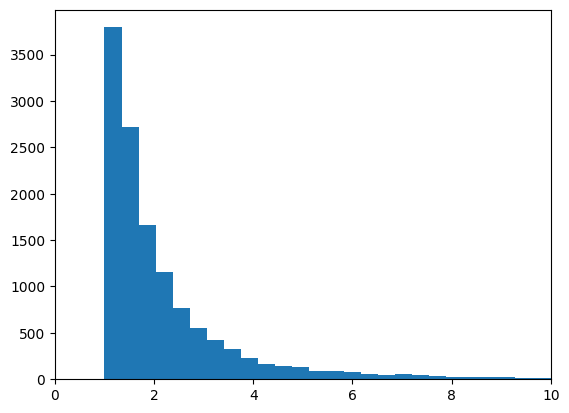

In [25]:
plt.hist(df_relRPP.PRR, bins=300);
plt.xlim(0, 10)

We can visualize some effects of couple of known (to me) drugs. We will use RPP field as importance of the word

In [26]:
from wordcloud import WordCloud

    
def plot_wordclout_for_drug(df, drugname):
    word_dict = df_relRPP.loc[df_relRPP['active_subs']==drugname, ['reaction', 'PRR']].set_index('reaction').to_dict()['PRR']
    wc = WordCloud(background_color="white",width=1000,height=1000, max_words=50,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(word_dict)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(drugname, fontsize=30)
    plt.show()
    

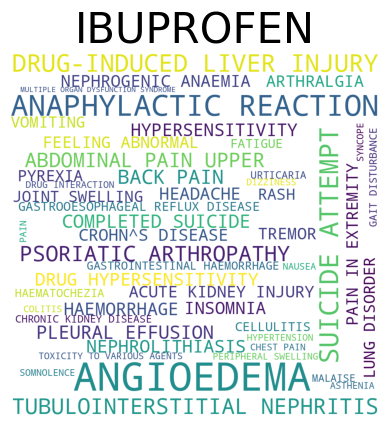

In [27]:
plot_wordclout_for_drug(df_relRPP, 'IBUPROFEN')

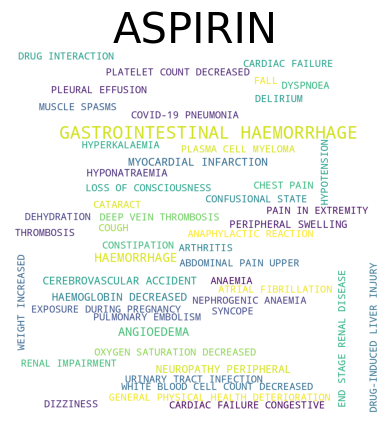

In [28]:
plot_wordclout_for_drug(df_relRPP, 'ASPIRIN')

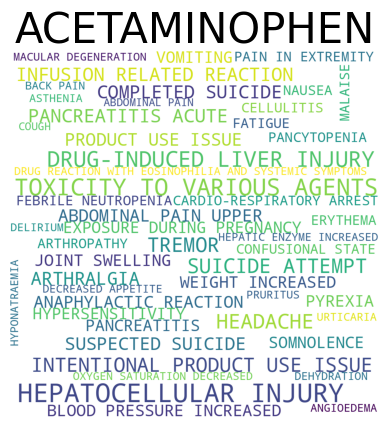

In [29]:
plot_wordclout_for_drug(df_relRPP, 'ACETAMINOPHEN')

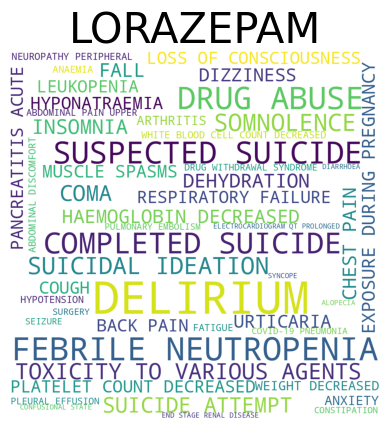

In [30]:
plot_wordclout_for_drug(df_relRPP, 'LORAZEPAM')

Let's use this information in a very naive way - to recommend possible alternatives for a given indication that have less adverse effects. For each drug indication we will get a list of possible active substances. We remove those that are ending either in DEATH or DRUG INEFFECTIVE (randomly chosen bad adverse effects)
This is just a toy application since:
1. the way we calculated relevant effects can suffer from data biases
2. we could, the most, establish correlation, not causality
3. the drug possible alternatives does not depend only on its indication 

In [31]:
df_relRPP.reaction.unique()

array(['ABDOMINAL DISCOMFORT', 'ABDOMINAL PAIN', 'ABDOMINAL PAIN UPPER',
       'ACUTE KIDNEY INJURY', 'ALOPECIA', 'ANAEMIA',
       'ANAPHYLACTIC REACTION', 'ANGIOEDEMA', 'ANXIETY', 'ARTHRALGIA',
       'ARTHRITIS', 'ARTHROPATHY', 'ASTHENIA', 'ASTHMA',
       'ATRIAL FIBRILLATION', 'BACK PAIN', 'BLADDER CANCER',
       'BLOOD PRESSURE INCREASED', 'BONE DENSITY DECREASED',
       'BREAST CANCER', 'CARDIAC DISORDER', 'CARDIAC FAILURE',
       'CARDIAC FAILURE CONGESTIVE', 'CARDIO-RESPIRATORY ARREST',
       'CATARACT', 'CELLULITIS', 'CEREBROVASCULAR ACCIDENT', 'CHEST PAIN',
       'COLITIS', 'COLITIS ULCERATIVE', 'COMA', 'CONDITION AGGRAVATED',
       'CONFUSIONAL STATE', 'CONSTIPATION',
       'CONTRAINDICATED PRODUCT ADMINISTERED', 'COUGH', 'COVID-19',
       'COVID-19 PNEUMONIA', 'CROHN^S DISEASE', 'DEATH',
       'DEEP VEIN THROMBOSIS', 'DELIRIUM', 'DEPRESSION',
       'DIABETES MELLITUS', 'DIARRHOEA', 'DISABILITY',
       'DISEASE PROGRESSION', 'DIZZINESS', 'DRUG DEPENDENCE',
     

In [32]:

drugs_to_avoid = df_relRPP.groupby('active_subs')['reaction'].apply(lambda x:any(x.isin(['DEATH', 'COMPLETED SUICIDE','SUICIDE ATTEMPT', 'SUSPECTED SUICIDE' ])))
drugs_to_avoid = drugs_to_avoid[drugs_to_avoid]


In [33]:
df_drug_ind = df[['active_subs', 'drugind']].dropna()
df_drug_ind = df_drug_ind[~df_drug_ind.drugind.isin(['PRODUCT USED FOR UNKNOWN INDICATION', 'DRUG ABUSE', 'WRONG DRUG'])]

In [34]:

df_drug_ind = df_drug_ind.assign(drug_avoid = df_drug_ind.active_subs.isin(drugs_to_avoid.index))


In [35]:
df_drug_alternatives = df_drug_ind[~df_drug_ind.drug_avoid].groupby('drugind')['active_subs'].apply(lambda x:set(x.tolist()))


In [36]:
df_drug_alternatives.head()

drugind
5-HYDROXYINDOLACETIC ACID                                  {TELOTRISTAT ETHYL}
ABDOMINAL ABSCESS            {CLAVULANATE POTASSIUM\TICARCILLIN, METRONIDAZ...
ABDOMINAL DISCOMFORT         {PREDNISONE, RANITIDINE, MESALAMINE, BENAZEPRI...
ABDOMINAL DISTENSION         {PREDNISONE, RANITIDINE, MESALAMINE, RANITIDIN...
ABDOMINAL HERNIA                        {RANITIDINE, RANITIDINE HYDROCHLORIDE}
Name: active_subs, dtype: object

##  Group diseases based on their adverse effects

Let's assume that the drug inication is reflecting patient disease (this does not have to hold, especially for non-prescribed drugs)

In [37]:
unique_ind = df['drugind'].value_counts().sort_values(ascending=False)

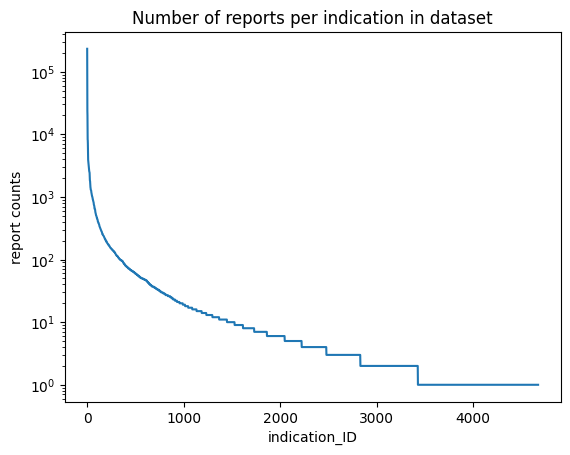

In [38]:
plt.plot(unique_ind.values)
plt.yscale('log')
plt.xlabel('indication_ID')
plt.ylabel('report counts')
plt.title('Number of reports per indication in dataset');

In [129]:
represented_indications = unique_ind[unique_ind>100]
print(f'Number of sufficiently represented indications is {len(represented_indications)}')

Number of sufficiently represented indications is 340


In [797]:
#select only part with most common reactions and indications
df_indic_ev = df.loc[df.reaction.isin(represented_reactions.index.values)&df.drugind.isin(represented_indications.index.values)&df.drugcar==1,['reaction', 'drugind']]

df_indic_ev = df_indic_ev[~df_indic_ev.drugind.isin(['PRODUCT USED FOR UNKNOWN INDICATION', 'DRUG ABUSE', 'WRONG DRUG'])].dropna()
print('number of different reactions', df_indic_ev.reaction.nunique())
print('number of different indications', df_indic_ev.drugind.nunique())

number of different reactions 182
number of different indications 338


In [799]:
df_indic_ev.head()

,reaction,drugind
15,RESPIRATORY FAILURE,COVID-19
54,DIZZINESS,ACUTE LYMPHOCYTIC LEUKAEMIA
56,RENAL CANCER,GASTROOESOPHAGEAL REFLUX DISEASE
57,RENAL CANCER,GASTROOESOPHAGEAL REFLUX DISEASE
58,RENAL CANCER,GASTROOESOPHAGEAL REFLUX DISEASE


In [820]:
df_drug_ev = df.loc[df.reaction.isin(represented_reactions.index.values)&df.drugind.isin(represented_indications.index.values),['reaction', 'active_subs']]
drug_reac_matr  = pd.crosstab(df_indic_ev.drugind, df_indic_ev.reaction)
data = drug_reac_matr.values

In [821]:
drug_reac_matr.head()

reaction,ABDOMINAL DISCOMFORT,ABDOMINAL PAIN,ABDOMINAL PAIN UPPER,ACUTE KIDNEY INJURY,ALOPECIA,ANAEMIA,ANAPHYLACTIC REACTION,ANGIOEDEMA,ANXIETY,ARTHRALGIA,...,TOXICITY TO VARIOUS AGENTS,TREATMENT FAILURE,TREMOR,TUBULOINTERSTITIAL NEPHRITIS,URINARY TRACT INFECTION,URTICARIA,VOMITING,WEIGHT DECREASED,WEIGHT INCREASED,WHITE BLOOD CELL COUNT DECREASED
drugind,,,,,,,,,,,,,,,,,,,,,
ABDOMINAL DISCOMFORT,2,1,1,1,0,0,0,0,1,2,...,0,0,0,0,1,0,1,0,0,0
ABDOMINAL PAIN,0,9,1,0,0,0,0,0,1,0,...,1,3,0,0,1,2,0,1,0,2
ABDOMINAL PAIN UPPER,1,0,8,0,0,3,0,0,0,1,...,0,0,1,0,1,0,1,2,0,0
ACNE,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,6,2,0,0,0
ACQUIRED IMMUNODEFICIENCY SYNDROME,0,0,0,11,0,0,0,0,8,0,...,0,1,0,0,0,0,1,0,0,0


This matrix contains counts of all reaction, indication pairs. 
The columns can be understood as feature vectors (ie how relevant each reaction is for a given disease).
Since the elements in the matrix are simple counts, we can simply divide each disease with the total number of counts for that disease.
This is important since it puts all diseases in similar scale - they only differ on relative proportions of different reactions

In [822]:
data=data/data.sum(axis=0)

Since the data is high-dimensional we can first use some dimensionality reduction tehnique before passing it through a clustering algorythm.

In [823]:
from umap import UMAP
embeddings = UMAP(n_neighbors=4, min_dist=0.0, n_components=2, random_state=42).fit_transform(data)

In [824]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=2).fit(embeddings)
labels = clustering.labels_
unique_labs = np.unique(labels)

In [825]:
unique_labs

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [826]:
colors_labels = {lab:np.random.rand(3,) for lab in unique_labs}


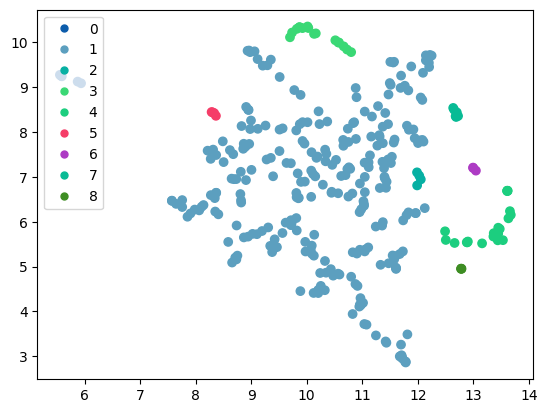

In [827]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots()
custom = [Line2D([], [], marker='.', markersize=10, color=color, linestyle='None') for color in colors_labels.values()]
scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], c=[colors_labels[l] for l in labels])

ax.legend(custom, list(colors_labels.keys()), loc='upper left', fontsize=10)


In [828]:
for lab in unique_labs:
    if (lab==-1):
        continue
    clustered = drug_reac_matr[labels==lab].index.values
    if len(clustered)<20:
        print(clustered, '\n')


['ABDOMINAL DISCOMFORT' 'DYSPEPSIA' 'EROSIVE OESOPHAGITIS' 'GASTRIC ULCER'
 'GASTROOESOPHAGEAL REFLUX DISEASE' 'HYPERCHLORHYDRIA' 'INTESTINAL ULCER'] 

['AFFECTIVE DISORDER' 'AGITATION'
 'ATTENTION DEFICIT HYPERACTIVITY DISORDER' 'TUBERCULOSIS'] 

['ANKYLOSING SPONDYLITIS' 'CEREBROVASCULAR ACCIDENT'
 'CHRONIC LYMPHOCYTIC LEUKAEMIA' 'CORONARY ARTERY DISEASE'
 'COVID-19 IMMUNISATION' 'CROHN^S DISEASE' 'DERMATITIS ATOPIC'
 'EMBOLISM VENOUS' 'LYMPHOCYTIC LEUKAEMIA' 'MUSCLE RELAXANT THERAPY'
 'NARCOLEPSY' 'POLYCYTHAEMIA VERA' 'PREMEDICATION' 'PSORIASIS'
 'PSORIATIC ARTHROPATHY' 'RHEUMATOID ARTHRITIS'] 

['CARDIAC FAILURE' 'DIABETES MELLITUS' 'HYPERTENSION'
 'TYPE 2 DIABETES MELLITUS'] 

['INTENTIONAL OVERDOSE' 'NEUROMYELITIS OPTICA SPECTRUM DISORDER'
 'SCHIZOAFFECTIVE DISORDER'] 

['MULTIPLE SCLEROSIS' 'MUSCLE SPASMS' 'MUSCLE SPASTICITY'
 'PRIMARY PROGRESSIVE MULTIPLE SCLEROSIS' 'RELAPSING MULTIPLE SCLEROSIS'
 'RELAPSING-REMITTING MULTIPLE SCLEROSIS'] 

['PARKINSON^S DISEASE' 'SUICIDE ATTEM

Most of the point belong to the same cluster meaning that there is not obvious distinguishing of the adverse effects among them. We might need both more statistics and smarter data preprocessing to imporove the result. 

Some of the clusters do make sense (for example the first are all stomach issues). This  can be either due to similar drug provoking similar effects or the desease itself is provoking adverse effect.

However these results are not to be taken for granted: creating feature vector for each drug indication has dubious statistics, clustering with manifold learning algorithyms for dimensionality reduction can introduce false patterns, etc